# Finding Best Hyperparameters for the Fashion - MNIST CNN
# Author: Huygens Ravelomanana
# Description
We create a random grid from scratch to find the best hyperparameters for a CNN classification model on the Fashion - MNIST data set from `tensorflow.keras.datasets `.

# Importing libraries

In [56]:
%matplotlib inline
# to store the plots within the notebook

# uncomment this line below if running on google colab
%tensorflow_version 2.x 

import random 
# setting seed for random in order to get reproducible results

import itertools

# to clear memory
# cuda help connect python with the GPU
#from numba import cuda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D,
                                     Flatten, Dense, Dropout)

from tensorflow.keras.optimizers import (SGD, Adam, Nadam,
                                         Adagrad, RMSprop, Adadelta)

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import initializers

sns.set(style="whitegrid")



# Loading data and short preparation
+ The data was already prepared for us and is already split into train and test sets.
     * Thus we will not do too much preparation and exploration.

In [2]:
# loading the data train and test sets from tensorflow dataset minst
# we load the data into /tmp partition
# we will split the main mnist train data further in train and validation
# that's why we use X_train_val y_train_val here instead of X_train, y_train
(X_train_val, y_train_val), (X_test, y_test) = fashion_mnist.load_data()

# splitting train_val data into train and validation
# to reduce randomness in the training we will provide validation_data
# instead of just a validation_split
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=1/12,
                                                  random_state=1)

# converting the target class vector into binary class matrix
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [3]:
# checking the shape of the data
print("\nTrain features shape: ", X_train.shape)
print("Train target shape: ",y_train.shape,"\n")
print("Validation features shape: ", X_val.shape)
print("Validation target shape: ", y_val.shape, "\n")
print("Test features shape: ", X_test.shape)
print("Test target shape: ", y_test.shape, "\n")


Train features shape:  (55000, 28, 28)
Train target shape:  (55000, 10) 

Validation features shape:  (5000, 28, 28)
Validation target shape:  (5000, 10) 

Test features shape:  (10000, 28, 28)
Test target shape:  (10000, 10) 



### Comment
+ From the shape we can see that we have 10 different classes.

## Printing some images

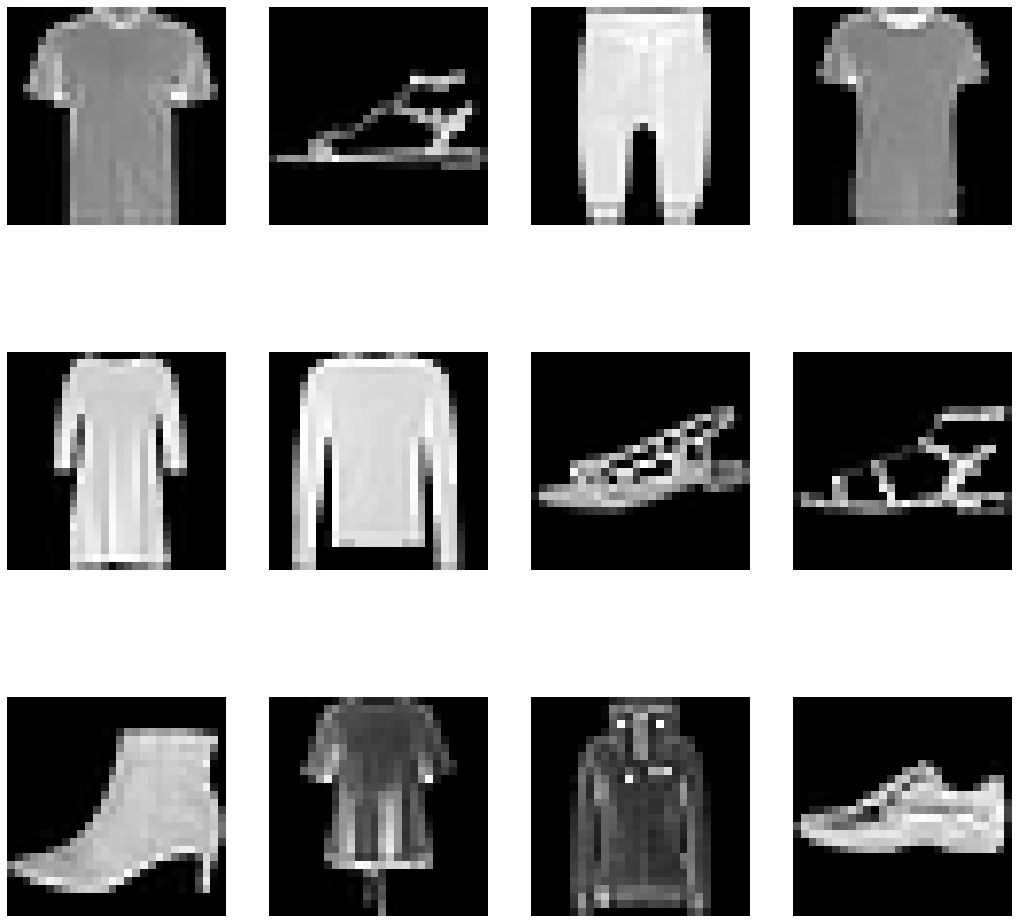

In [4]:
# printing random images from train, validation, and test sets

# defining some variable
# in case we make the printing into a function later
data = X_train
n_sample = X_train.shape[0]

# creating axis for the plot
fig, axes = plt.subplots(3, 4, figsize=(18,18))

# flattening the axis array into 1D
axes = axes.ravel()

for i in range(12):
    # random index for train data
    index = random.randint(0,n_sample-1)

    # showing the image
    axes[i].imshow(data[index], cmap=plt.get_cmap('gray'))

    # not showing the axis (we just want to see image)
    axes[i].axis('off')
        
# show the figure
plt.show()


In [5]:
# looking at the max and min value of the training features.
print("minimum value: ", X_train.min(), "\n",
      "maximum value: ", X_train.max())

minimum value:  0 
 maximum value:  255


## Scalling the input
+ We are going to scale all the images so that the values fall in the $[0,1]$ range instead of the $[0,255]$. This is in order to make the weights small.

In [6]:
# creating a function for the scaling
def scale_array_elt(img_arr):
    """Function scaling all the images in the array img_arr
    which is an array of image samples.
    Input:
    -----
          img_arr (numpy.ndarray): numpy array of shape (N, H, W)
                                   where N is the number of images
                                   H is the height of each image
                                   W is the widt hof each image
    
    Ouput:
    -----
          img_arr_copy (numpy.ndarray): numpy array with the same shape
                                    as the input.
    """
    img_arr_copy = img_arr

    # looping through all the samples
    for i in range(img_arr.shape[0]):
        #scaling an image matrix
        np.true_divide(img_arr_copy[i], 255)
    
    return img_arr_copy
    
#scaling all images in the datasets
X_train = scale_array_elt(X_train)
X_val = scale_array_elt(X_val)
X_test = scale_array_elt(X_test)

### Comment
+ Convolution 2D (Conv2D) takes an extra arguments which is channel.
    * However the feature data is a numpy array of shape (60000, 28, 28) i.e 60000 samples of 28 pixels x 28 pixels images.
    * Therefore we will add channel as a 4th axis to the feature data.
    * This way each sample will consist of a 28 pixels x 28 pixels plus 1 channel

In [7]:
# the feature data is a numpy array of spa
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# looking at the new shape of the features
X_train.shape, X_val.shape, X_test.shape

((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

# Creating lists of hyperparameters

In [8]:
# list of learning rates
lr_list = [0.0001, 0.001]

# list of initializers
initializers_list = ['glorot_normal',
                'glorot_uniform',
                'lecun_normal']

# list of batch size
batch_size_list = [16, 32, 64]

# list of optimizers
# the learning rate argument lr will be one of the learning rate in lr_list
# the string in this list will be evaluated using built-in eval() function
optimizers_list = ['SGD(learning_rate=lr, momentum=0.3, nesterov=True)',
                   'Adam(learning_rate=lr)',
                   'Adagrad(learning_rate=lr)',
                   'Nadam(learning_rate=lr)',
                   'RMSprop(learning_rate=lr)']

# other optimizers we can choose from
# SGD(learning_rate=lr), the simple SGD
#'SGD(learning_rate=lr, momentum=0.6)'
# Adamax(learning_rate=lr)
# Adadelta(learning_rate=lr)
# Ftrl(learning_rate=lr)


## Creating a cartesian product of the 4 lists above
+ `lr_list` has length 2
+ `initializers_list` has length 3
+ `batch_size_list` has length 3
+ `optimizers_list` has length 5

Therefore there are 2 x 3 x 3 x 6 = 90 different possible combinations of parameters.<br>
The next code below will create these different combinations.

In [9]:
# creating the different possible combinations of  hyperparameters based
# on our 4 lists of hyperparameters values.
hyperparameters_iter = itertools.product(lr_list,
                                         initializers_list,
                                         batch_size_list,
                                         optimizers_list)

# itertools.product() returns an iterator so we have to convert it into a list
hyperparameters_list = list(hyperparameters_iter)


In [10]:
# checking the length of the list of all possible combinations
len(hyperparameters_list)

90

# Defining functions which do the model creation and fitting

In [84]:
# defining a training function

#lr, initializer, batch_size, optimizer
def create_cnn_model(lr, initializer, optimizer):
    """Creating and compiling a cnn model using keras.models.Sequential().
    INPUT:
    ------
          lr (str): value of the learning rate in string. The learning rate
              will be directly used by the optimizer parameter and will not
              be seen in this code. It is passed as a parameters so that the
              variable lr appears in this function local  scope of variable.
            
          initializer (str): string values for tf.keras.initializers classes.
          
          optimizer (str): to be evaluated by the built in eval() function.
                     must be one of tf.keras.optimizers optimizer classes
                     when evaluated, the corresponding class must have been
                     properly imported in the python session.
    
    OUTPUT:
    -------
          model (tensorflow.python.keras.engine.sequential.Sequential):
                 the compiled model
    """

    # creating and instance of keras Sequential class
    model = Sequential()

    # first fully connected layer - Convolution layers
    # ================================================
    
    # first convolutional layer
    model.add(Conv2D(64, (3, 3),
                     strides=(1, 1),
                     activation='tanh',
                     input_shape=(28, 28, 1),
                     kernel_initializer='lecun_normal'))
    
    # downsampling
    model.add(MaxPool2D((2,2), strides=(2, 2)))
    #model.add(MaxPool2D((2,2)))

    # second convolutional layer
    model.add(Conv2D(64, (2, 2),
                     strides=(1, 1),
                     activation='tanh',
                     kernel_initializer='lecun_normal'))
    # downsampling
    model.add(MaxPool2D((2,2), strides=(2, 2)))
    #model.add(MaxPool2D((2,2)))

    # second fully connected layer
    # ================================================
    
    # first we have to flatten the tensor into 1D array 
    model.add(Flatten())

    # Dense layers - Neural Network

    # dropping out some neurons
    model.add(Dropout(0.4))

    model.add(Dense(256, activation='relu', kernel_initializer=initializer))

    # dropping out some neurons
    model.add(Dropout(0.4))

    # hiddern layer
    model.add(Dense(128, activation='relu', kernel_initializer=initializer))
    
    # output layer
    model.add(Dense(10, activation='softmax'))

    # compiling the model
    model.compile(optimizer=eval(optimizer),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def fit_model(model, batch_size, epochs):
    """Fitting the model model given as parameters.
    INPUT:
    ------
          model (tensorflow.python.keras.engine.sequential.Sequential):
                    an already compiled keras Sequential model with
                    different layers            
          
          batch_size (int): batch size to be used during each epoch of training.
          
          epochs (int): number of epochs for the training.
    
    OUTPUT:
    -------
          history (tensorflow.python.keras.callbacks.History): History for the
                 model training
          
          test_results: result of the testing on the test data
          
    """
    # we are using early stopping callback to prevent the model from
    # training for more epochs than needed, it will save time and resources.
    my_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                   patience=2)

    # fitting the model
    # we use the globally defined train and validation data
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[my_callback],
                        verbose=0)
    
    # Evaluating the model on the test data
    # we use the globally defined test data
    # we choose a fix batch size for the evaluation
    test_results = model.evaluate(X_test, y_test,
                                  batch_size=64,
                                  verbose=0)
    
    return history, test_results



# Randomly choosing 10 different combinations among all the possible one

In [85]:
# using random.sample to randomly pick 10 hyperparameters combinations
# out of all the possible one in parameters_list

# setting seed for random in order to get reproducible results
random.seed(1)
random_hyperparameters = random.sample(hyperparameters_list, 10)

# looking at the samples
random_hyperparameters

[(0.0001, 'glorot_uniform', 16, 'Adagrad(learning_rate=lr)'),
 (0.001, 'glorot_uniform', 64, 'Adagrad(learning_rate=lr)'),
 (0.0001, 'glorot_normal', 32, 'Nadam(learning_rate=lr)'),
 (0.0001, 'lecun_normal', 16, 'Adagrad(learning_rate=lr)'),
 (0.0001,
  'glorot_uniform',
  16,
  'SGD(learning_rate=lr, momentum=0.3, nesterov=True)'),
 (0.001, 'glorot_uniform', 16, 'Nadam(learning_rate=lr)'),
 (0.001, 'glorot_normal', 64, 'Adagrad(learning_rate=lr)'),
 (0.001,
  'glorot_uniform',
  16,
  'SGD(learning_rate=lr, momentum=0.3, nesterov=True)'),
 (0.001, 'lecun_normal', 32, 'Nadam(learning_rate=lr)'),
 (0.001, 'glorot_normal', 16, 'Nadam(learning_rate=lr)')]

# Creating and training the 10 models based on the previously sampled combinations

In [86]:
%%time
# magic command for getting the execution time of the this cell



# setting random seed to get reproducible results
random.seed(1)    # python random seed
np.random.seed(1)  # numpy random seed
tf.random.set_seed(1) # tensorflow global random seed
tf.compat.v1.set_random_seed(1) # tensorflow graph level random seed


# creating a dictionary  to keep track of training of each model
# the keys of the dictionary will be hyperparameters combinations
histories = {}

# creating a dictionary to keep track of the test result for each model
# same keys as above
test_dic = {}

# looping through all the randomly choosen combination of hyperparameters
# creating and  training the corresponding model
for hyperparameters in random_hyperparameters:

    # Removes all data from previous models (freeing memory)
    K.clear_session()

    # more step for clearing memory if using GPU
    #cuda.select_device(0)
    #cuda.close()

    # unpacking the hyperparameters
    lr, initializer, batch_size, optimizer = hyperparameters

    # creating and compiling the corresponding model
    cnn_model = create_cnn_model(lr, initializer, optimizer)
    
    # fitting / trainig the model
    # If we run the notebook on google colab,
    # the maximum number of epochs we can do for this model is 8
    # higher epoch will cause the error:
    # your session crashed after using all available RAM. 
    history, test_results = fit_model(cnn_model, batch_size, epochs=20)
    
    # saving training history in a pandas DataFrame
    histories[hyperparameters] = pd.DataFrame(history.history,
                                              index=history.epoch)
    
    # saving the test result for the corresponding 
    # hyperparameters combination
    test_dic[hyperparameters] = test_results
    
    print("Training done for: ", hyperparameters, end='\n')


Training done for:  (0.0001, 'glorot_uniform', 16, 'Adagrad(learning_rate=lr)')
Training done for:  (0.001, 'glorot_uniform', 64, 'Adagrad(learning_rate=lr)')
Training done for:  (0.0001, 'glorot_normal', 32, 'Nadam(learning_rate=lr)')
Training done for:  (0.0001, 'lecun_normal', 16, 'Adagrad(learning_rate=lr)')
Training done for:  (0.0001, 'glorot_uniform', 16, 'SGD(learning_rate=lr, momentum=0.3, nesterov=True)')
Training done for:  (0.001, 'glorot_uniform', 16, 'Nadam(learning_rate=lr)')
Training done for:  (0.001, 'glorot_normal', 64, 'Adagrad(learning_rate=lr)')
Training done for:  (0.001, 'glorot_uniform', 16, 'SGD(learning_rate=lr, momentum=0.3, nesterov=True)')
Training done for:  (0.001, 'lecun_normal', 32, 'Nadam(learning_rate=lr)')
Training done for:  (0.001, 'glorot_normal', 16, 'Nadam(learning_rate=lr)')
CPU times: user 21min 18s, sys: 3min 5s, total: 24min 24s
Wall time: 16min 53s


# Comparing the 10 different models
+ We will visualize the curves of:
    * training loss and training accuracy first
    * then the curves of validation loss and validation accuracy
+ We will look more closely at the corresponding dataframes for better insight
+ Finally we will look at the test results

In [114]:
# Creating a function which plots loss or accuracy curve
def plot_curves(type_of_plot, title, ylabel):
    """Function plotting loss or accuracy (depending on type_of_plot parameter)
    for the 12 different combinations of hyperparameters.

    INPUT:
    -----   
            type_of_plot (str): the possible values are
                        'loss' (training loss),
                        'accuracy' (training accuracy)
                        'val_loss'(validation loss),
                        'val_accuracy' (validation accuracy).

            title (str): the title of the plot.

            ylabel (str), ylabel for the plot.

    OUTPUT:
    ------
            None (it shows a plot)
    """

    # color palette to be used for the 12 different curves
    color_palette = sns.color_palette("tab20", n_colors=12)

    ## creating figure and axis for the plot
    loss_figure = plt.figure(figsize=(10, 10))
    axes = loss_figure.gca()
    axes.set_title(title, fontsize=15)
    axes.set_ylabel(ylabel, fontsize=15)
    axes.set_xlabel('Epoch number', fontsize=15)

    # looping through all the randomly choosing combination of hyperparameters 
    # and plotting the corresponding curves
    for hyperparameters, color in zip(random_hyperparameters, color_palette):

        axes.plot(histories[hyperparameters][type_of_plot],
                color=color,
                label=hyperparameters,
                linewidth=3)

    # adding legend to the plot
    axes.legend(loc='upper right', bbox_to_anchor=(2.3, 1), fontsize=15)
    axes.set_xticks(list(range(0, 21, 2)))

    plt.show()


### Training loss and accuracy vs epoch for the 10 models

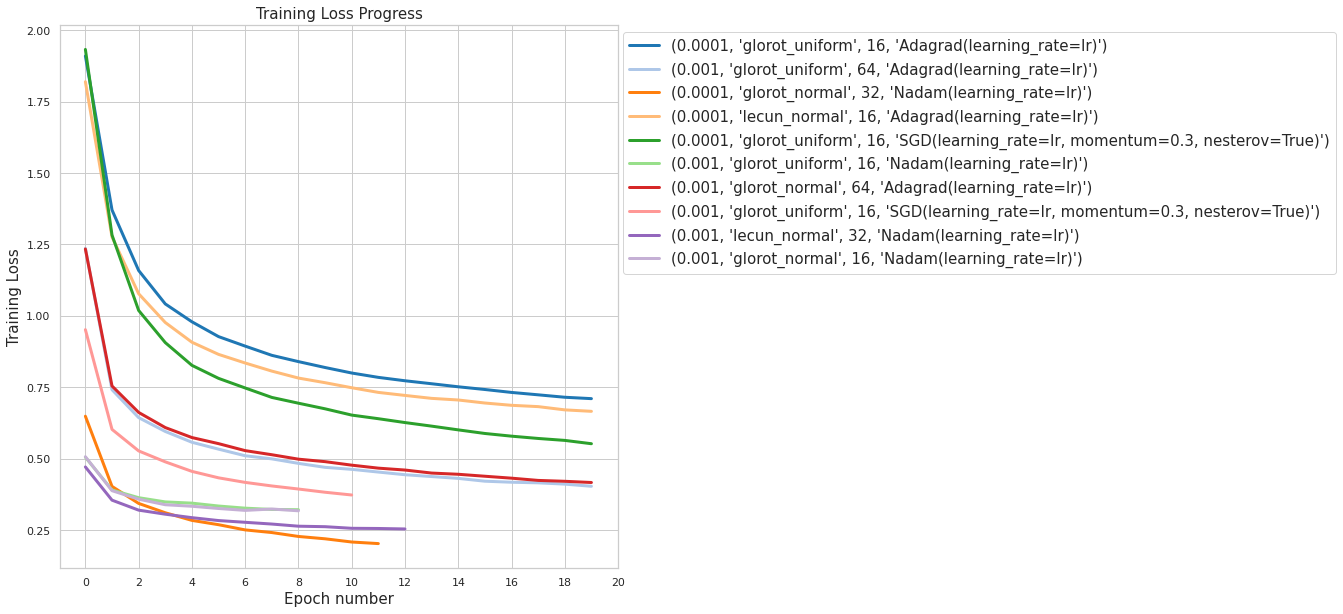

In [115]:
%matplotlib inline
# to store the plots within the notebook

# plotting the curves of training loss vs epochs for the 12 models
plot_curves('loss', 'Training Loss Progress', 'Training Loss')

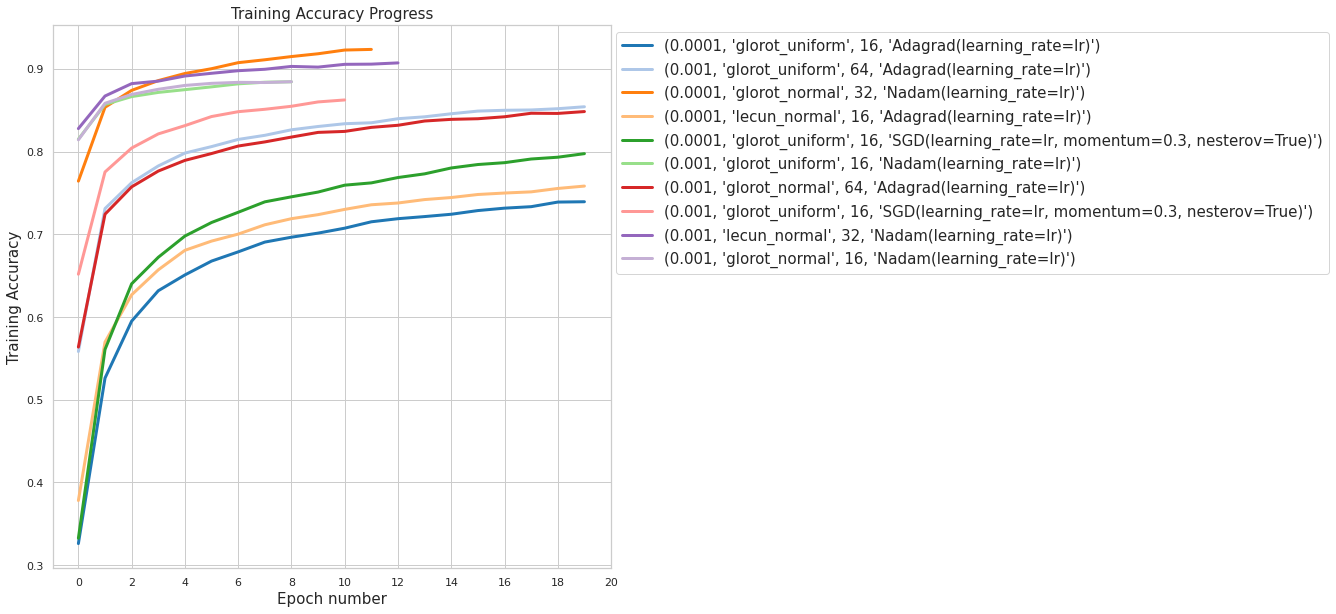

In [116]:
%matplotlib inline
# to store the plots within the notebook

# plotting the curves of training accuracy vs epochs for the 12 models
plot_curves('accuracy',
            'Training Accuracy Progress',
            'Training Accuracy')

### Validation loss and accuracy vs epoch for the 10 models

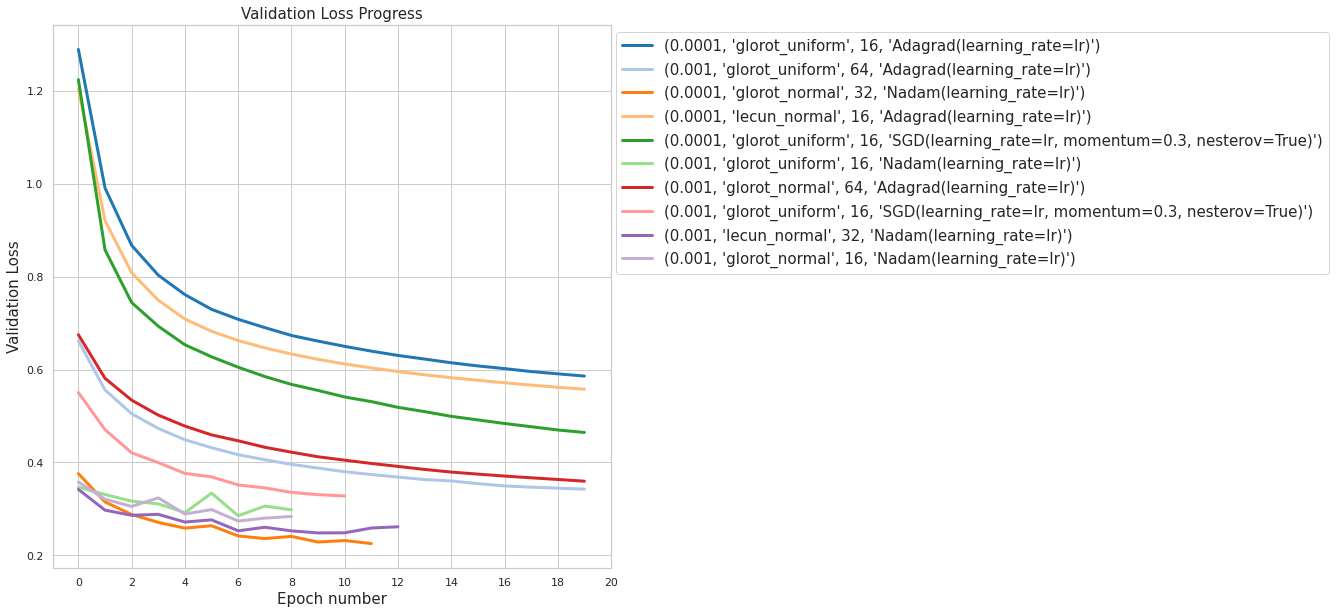

In [117]:
%matplotlib inline
# to store the plots within the notebook

# plotting the curves of validation loss vs epochs for the 12 models
plot_curves('val_loss', 'Validation Loss Progress', 'Validation Loss')

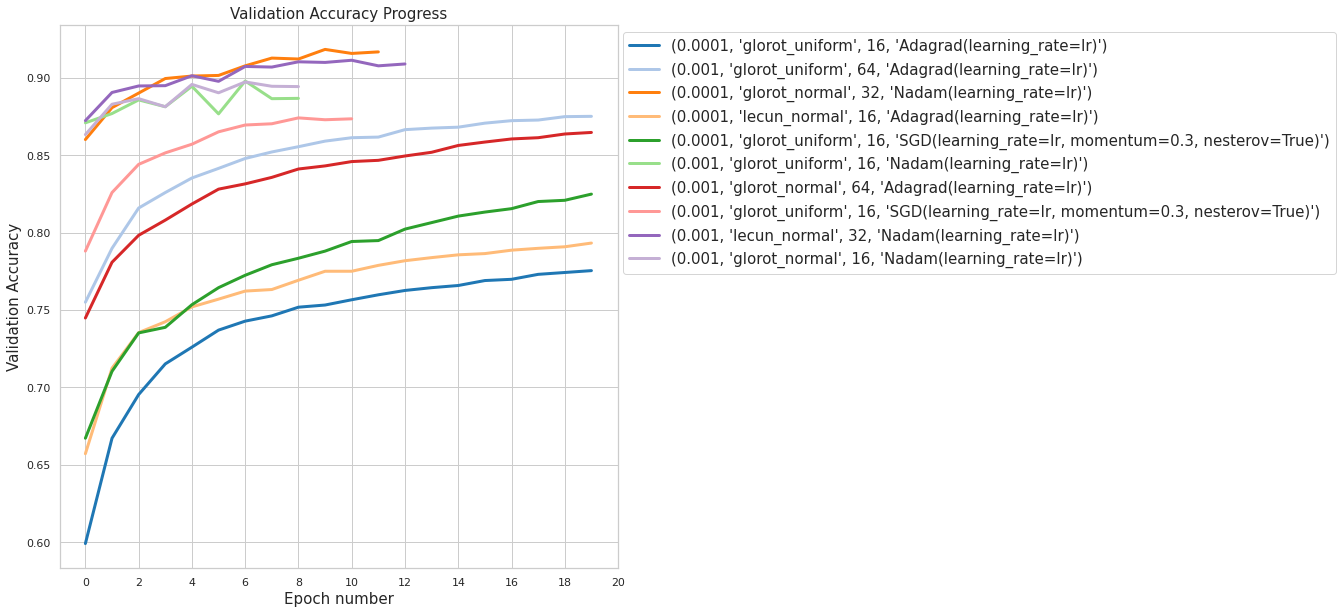

In [118]:
%matplotlib inline
# to store the plots within the notebook

# plotting the curves of validation accuracy vs epochs for the 12 models
plot_curves('val_accuracy',
            'Validation Accuracy Progress',
            'Validation Accuracy')

### Last  epoch accuracy for the 10 different models
+ We do this to better understand the pictures  above.

In [92]:
# creating a pd dataframe with indices the 10 different hyperparameters
# combination and column the last epoch values for training accuracy and
# validation accuracy

# creating an empty dictionary to be used for creating the data frame
acc_dic = {}

# looping through all the 10 combinations to ge the last epoch training
# accuracy and validation accuracy
for hyperparam in random_hyperparameters:
    acc_dic[hyperparam] = [histories[hyperparam].accuracy.iloc[-1],
                           histories[hyperparam].val_accuracy.iloc[-1],
                           histories[hyperparam].shape[0]]

# histories[hyperparam].shape[0] corresponds to the number of training epochs
# for hyperparam.  Early stopping may have been triggered, leading to
# a smaller number of epochs than the one provided in the .fit() method

# creating the dataframe
acc_df = pd.DataFrame.from_dict(acc_dic, orient='index',
                                columns=['training_accuracy',
                                         'validation_accuracy',
                                         'number_of_epochs'])


In [108]:
# looking at the last epoch training accuracy in decreasing order
acc_df.sort_values('training_accuracy', ascending=False)

,training_accuracy,validation_accuracy,number_of_epochs
"(0.0001, glorot_normal, 32, Nadam(learning_rate=lr))",0.923618,0.9166,12
"(0.001, lecun_normal, 32, Nadam(learning_rate=lr))",0.907309,0.9088,13
"(0.001, glorot_normal, 16, Nadam(learning_rate=lr))",0.884582,0.8942,9
"(0.001, glorot_uniform, 16, Nadam(learning_rate=lr))",0.884473,0.8866,9
"(0.001, glorot_uniform, 16, SGD(learning_rate=lr, momentum=0.3, nesterov=True))",0.862509,0.8734,11
"(0.001, glorot_uniform, 64, Adagrad(learning_rate=lr))",0.854273,0.8750,20
"(0.001, glorot_normal, 64, Adagrad(learning_rate=lr))",0.848473,0.8646,20
"(0.0001, glorot_uniform, 16, SGD(learning_rate=lr, momentum=0.3, nesterov=True))",0.797582,0.8248,20
"(0.0001, lecun_normal, 16, Adagrad(learning_rate=lr))",0.758382,0.7932,20
"(0.0001, glorot_uniform, 16, Adagrad(learning_rate=lr))",0.739436,0.7754,20


In [94]:
# looking at the last epoch validation accuracy in decreasing order
acc_df[['validation_accuracy', 'number_of_epochs']].sort_values('validation_accuracy', ascending=False)

,validation_accuracy,number_of_epochs
"(0.0001, glorot_normal, 32, Nadam(learning_rate=lr))",0.9166,12
"(0.001, lecun_normal, 32, Nadam(learning_rate=lr))",0.9088,13
"(0.001, glorot_normal, 16, Nadam(learning_rate=lr))",0.8942,9
"(0.001, glorot_uniform, 16, Nadam(learning_rate=lr))",0.8866,9
"(0.001, glorot_uniform, 64, Adagrad(learning_rate=lr))",0.8750,20
"(0.001, glorot_uniform, 16, SGD(learning_rate=lr, momentum=0.3, nesterov=True))",0.8734,11
"(0.001, glorot_normal, 64, Adagrad(learning_rate=lr))",0.8646,20
"(0.0001, glorot_uniform, 16, SGD(learning_rate=lr, momentum=0.3, nesterov=True))",0.8248,20
"(0.0001, lecun_normal, 16, Adagrad(learning_rate=lr))",0.7932,20
"(0.0001, glorot_uniform, 16, Adagrad(learning_rate=lr))",0.7754,20


# Test Accuracy Comparison

In [95]:
# creating a data frame
test_results_df = pd.DataFrame.from_dict(test_dic, orient='index',
                                         columns=['test_loss',
                                                  'test_accuracy'])

# viewing the test result dataframe in decreasing order of accuracy
test_results_df.sort_values('test_accuracy', ascending=False)

,test_loss,test_accuracy
"(0.0001, glorot_normal, 32, Nadam(learning_rate=lr))",0.238618,0.9121
"(0.001, lecun_normal, 32, Nadam(learning_rate=lr))",0.262949,0.9061
"(0.001, glorot_normal, 16, Nadam(learning_rate=lr))",0.278964,0.8965
"(0.001, glorot_uniform, 16, Nadam(learning_rate=lr))",0.305392,0.8862
"(0.001, glorot_uniform, 16, SGD(learning_rate=lr, momentum=0.3, nesterov=True))",0.338944,0.8762
"(0.001, glorot_uniform, 64, Adagrad(learning_rate=lr))",0.358276,0.8709
"(0.001, glorot_normal, 64, Adagrad(learning_rate=lr))",0.375529,0.8636
"(0.0001, glorot_uniform, 16, SGD(learning_rate=lr, momentum=0.3, nesterov=True))",0.472494,0.8263
"(0.0001, lecun_normal, 16, Adagrad(learning_rate=lr))",0.565472,0.7911
"(0.0001, glorot_uniform, 16, Adagrad(learning_rate=lr))",0.593068,0.7772


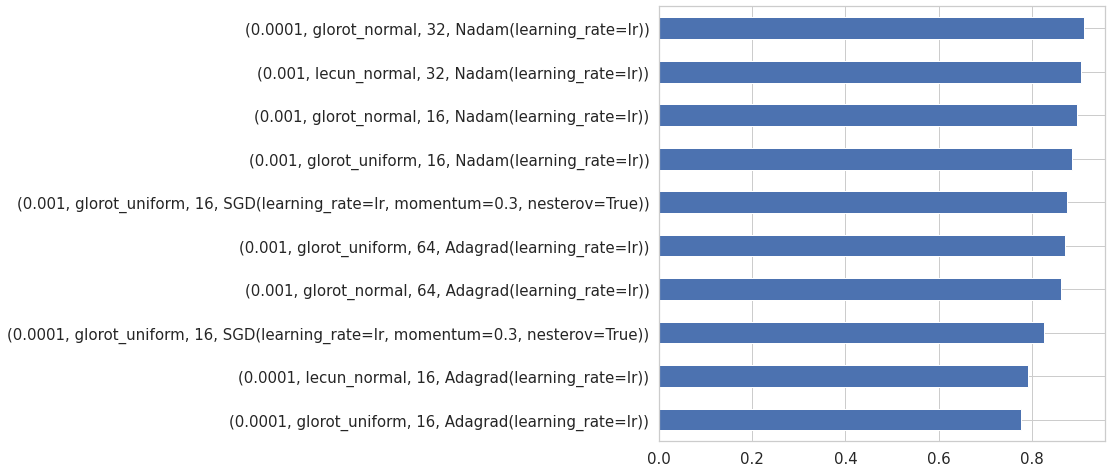

In [96]:
%matplotlib inline
# to store the plots within the notebook

# histogram of the test result
_ = test_results_df.test_accuracy.sort_values(
                 ).plot.barh(figsize=(8,8), fontsize=15)



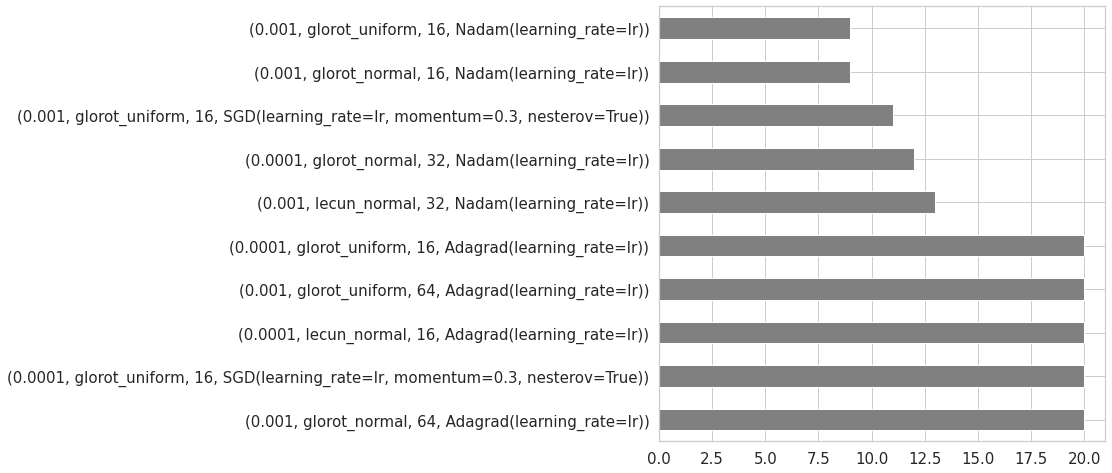

In [97]:
%matplotlib inline
# to store the plots within the notebook

# histogram of the number of epochs needed for training for each of the model
_ = acc_df.number_of_epochs.sort_values(ascending=False
                                        ).plot.barh(figsize=(8,8),
                                                    color='grey',
                                                    fontsize=15
                                                    )

#**Best model based on the results above:**
+ Traing and number of epochs needed for training
+ Validation accuracy
+ Test accuracy

**<font color="green">The best model is the one with the following accuracy and hyperparameters:</font>**
+ **<font color="green">Test accuracy: 0.9121.</font>**
+ Learning rate: `0.0001`
+ Initializer: `'glorot_normal'`
+ Batch size: `32`
+ Optimizer: `Nadam(learning_rate=lr)`
+ Max epoch: `12`

<font color="blue">The second best model is the one with the following accuracyand hyperparameters:</font>
+ **<font color="blue">Test accuracy: 0.9061.</font>**
+ Learning rate: `0.001`
+ Initializer: `'lecun_normal'`
+ Batch size: `32`
+ Optimizer: `Nadam(learning_rate=lr)`
+ Max epoch: `13`  
